## Setup

In [200]:
import pandas as pd
import matplotlib.pyplot as plt

## Limpeza inicial

Começaremos realizando a leitura do arquivo, utilizando a biblioteca `pandas`.

In [201]:
# Arquivo retirado de https://www.kaggle.com/datasets/realkiller69/gaia-stars-dataset-from-dr3-data-release-3
nome_arquivo = "C:\\Users\\Marcelo\\Downloads\\dataGaia2.csv"
df = pd.read_csv(nome_arquivo)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626016 entries, 0 to 626015
Data columns (total 50 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  626016 non-null  int64  
 1   RA_ICRS     626016 non-null  float64
 2   DE_ICRS     626016 non-null  float64
 3   Source      626016 non-null  int64  
 4   e_RA_ICRS   626016 non-null  float64
 5   e_DE_ICRS   626016 non-null  float64
 6   Plx         626016 non-null  float64
 7   e_Plx       626016 non-null  float64
 8   PM          626016 non-null  float64
 9   pmRA        626016 non-null  float64
 10  e_pmRA      626016 non-null  float64
 11  pmDE        626016 non-null  float64
 12  e_pmDE      626016 non-null  float64
 13  RUWE        626016 non-null  float64
 14  Gmag        626015 non-null  float64
 15  e_Gmag      626015 non-null  float64
 16  BPmag       626015 non-null  float64
 17  e_BPmag     626015 non-null  float64
 18  RPmag       626016 non-null  float64
 19  e_

O arquivo inicial possui mais de 230 MB. Para reduzir o espaço utilizado, assim como a memória, iniciaremos removendo algumas colunas.

In [202]:
# Seleção de colunas relevantes
colunas = [
    "E(BP-RP)",    # cor da estrela
    "GMAG",        # magnitude absoluta
    "Teff",        # temperatura efetiva
    "Dist",        # distância
    "SpType-ELS",  # classe espectral
    "Lum-Flame",   # luminosidade
    "Mass-Flame",  # massa
    "Age-Flame",   # idade
    "Rad",         # raio da estrela
    "PWD",         # probabilidade de ser uma anã branca
    "Pstar",       # probabilidade de ser uma estrela (sem ser anã branca)
    "PGal",        # probabilidade de ser uma galáxia
    "Plx",
    "e_Gmag",
    "e_BPmag",
    "e_RPmag",
    "AG"
]

df["BP-RP"] = df["BPmag"] - df["RPmag"]
df["BP-RP_corr"] = df["BP-RP"] - df["E(BP-RP)"]
df = df.dropna(subset=["BPmag", "RPmag"])
colunas.append("BP-RP_corr")

df = df[colunas]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 626015 entries, 0 to 626015
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   E(BP-RP)    626015 non-null  float64
 1   GMAG        626015 non-null  float64
 2   Teff        626015 non-null  float64
 3   Dist        626015 non-null  float64
 4   SpType-ELS  626015 non-null  object 
 5   Lum-Flame   611292 non-null  float64
 6   Mass-Flame  590795 non-null  float64
 7   Age-Flame   544680 non-null  float64
 8   Rad         626015 non-null  float64
 9   PWD         626015 non-null  float64
 10  Pstar       626015 non-null  float64
 11  PGal        626015 non-null  float64
 12  Plx         626015 non-null  float64
 13  e_Gmag      626015 non-null  float64
 14  e_BPmag     626015 non-null  float64
 15  e_RPmag     626015 non-null  float64
 16  AG          626015 non-null  float64
 17  BP-RP_corr  626015 non-null  float64
dtypes: float64(17), object(1)
memory usage: 90.7+ MB


In [203]:
df.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,626015.000000,626015.000000,626015.000000,626015.000000,611292.000000,590795.000000,544680.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000,626015.000000
mean,0.624456,2.232903,7295.089104,2150.402346,114.627988,1.841870,3.776441,8.030583,0.010132,0.971183,0.000003,1.466433,0.002857,0.004335,0.004406,1.134366,0.677839
std,0.598189,2.697245,3769.970949,3216.575605,330.115281,1.004918,4.139874,27.666631,0.099455,0.166293,0.000547,2.015174,0.000566,0.004819,0.002519,1.060195,0.647212
min,0.000000,-7.961700,3039.229700,10.519300,0.034732,0.500000,0.200000,0.345400,0.000000,0.000001,0.000000,-5.014100,0.002757,0.002794,0.003781,0.000000,-1.174750
25%,0.219600,0.340400,5217.458000,586.924150,2.066951,1.041000,0.524000,1.345000,0.000000,0.999915,0.000000,0.313100,0.002765,0.002917,0.003819,0.401300,0.129491
50%,0.417200,1.979300,5957.610400,1104.664800,11.679543,1.649000,1.448000,2.056100,0.000000,0.999976,0.000000,0.850400,0.002772,0.003126,0.003875,0.770100,0.719116
75%,0.877200,3.919600,8391.985000,2607.730750,60.254360,2.462000,6.629000,4.007600,0.000000,0.999995,0.000000,1.633600,0.002796,0.003812,0.004012,1.611000,0.967513
max,4.116100,9.963000,41504.020000,35666.805000,3499.921000,7.521000,13.500000,1105.995600,0.999950,1.000000,0.308608,95.047700,0.065528,0.323298,0.179498,7.185600,3.961059


A filtragem realizada considerará que:
- O objeto observado deve ter baixa probabilidade de ser uma galáxia (`Pgal < 0.1`)
- O objeto deve ter alta probabilidade de ser uma estrela padrão ou de ser uma anã branca (`Pstar > 0.9` ou `PWD > 0.9`)
- A paralaxe do objeto seve ser positiva (`Plx > 0`)
- Os erros fotométricos devem ser baixos (`e_Gmag < 0.05; e_BPmag, e_RPmag < 0.1`)
- A imagem deve ter baixa extinção (`AG < 0.5`)

In [ ]:
# Objetos adequados em probabilidade
df = df[((df['Pstar'] > 0.9) | (df['PWD'] > 0.9)) & (df['PGal'] < 0.1)]

# Paralaxe positiva
df = df[df['Plx'] > 0]

# Remoção de erros fotométricos grandes
df = df[df['e_Gmag'] < 0.05]
df = df[df['e_BPmag'] < 0.1]
df = df[df['e_RPmag'] < 0.1]

# Remoção de alta extinção
# df = df[df['AG'] < 0.5]

df.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,618751.000000,618751.000000,618751.000000,618751.000000,610341.000000,589871.000000,543915.000000,618751.000000,618751.000000,618751.000000,618751.000000,618751.000000,618751.000000,618751.000000,618751.000000,618751.000000,618751.000000
mean,0.621208,2.267832,7169.757061,2028.298056,113.875544,1.839890,3.780464,8.038736,0.008674,0.972721,0.000002,1.485100,0.002850,0.004263,0.004348,1.128630,0.686657
std,0.593804,2.687822,3470.819660,2864.946909,328.501088,1.003327,4.141097,27.734196,0.092145,0.161875,0.000489,2.019299,0.000484,0.004342,0.002213,1.052703,0.642535
min,0.000000,-7.961700,3039.229700,10.519300,0.034732,0.500000,0.200000,0.345400,0.000000,0.000001,0.000000,0.000100,0.002757,0.002794,0.003781,0.000000,-1.174750
25%,0.219200,0.374500,5208.798000,581.725000,2.062450,1.040000,0.526000,1.337300,0.000000,0.999915,0.000000,0.323000,0.002765,0.002915,0.003819,0.400600,0.175358
50%,0.415000,2.021800,5942.173300,1087.787600,11.609557,1.647000,1.453000,2.047000,0.000000,0.999976,0.000000,0.864800,0.002772,0.003120,0.003873,0.766000,0.723486
75%,0.873500,3.937000,8163.635350,2549.561750,59.907860,2.459000,6.639000,3.991500,0.000000,0.999994,0.000000,1.648600,0.002794,0.003778,0.004004,1.604600,0.970583
max,4.114700,9.963000,41504.020000,35666.805000,3499.921000,7.521000,13.500000,1105.995600,0.999950,1.000000,0.308608,95.047700,0.027048,0.099726,0.092315,7.185600,3.961059


Note que existem linhas com os valores `SpType-ELS`, `Lum-Flame` e `Mass-Flame` vazios. 

Como o dataset possui centenas de milhares de objetos, e a remoção de dados não deve prejudicar a análise, inicialmente as linhas com dados incompletos podem ser removidas. Porém, há um viés que será observado posteriormente para as anãs brancas, e por isso, a remoção não será realizada.

A fim de reduzir o tamanho do arquivo e reduzir o tempo necessário para as análises, será utilizado um subconjunto dos dados filtrados, escolhido aleatoriamente.

In [205]:
df_sample = df.sample(n=100000, random_state=67)
df_sample.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,100000.000000,100000.000000,100000.000000,100000.000000,98669.000000,95300.000000,87964.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.618744,2.272678,7162.738359,2021.063926,113.567658,1.836187,3.774380,8.008194,0.008187,0.973312,5.165178e-07,1.491431,0.002852,0.004284,0.004353,1.124045,0.686516
std,0.594119,2.681839,3453.985627,2867.884506,328.109644,0.998828,4.137437,27.131994,0.089515,0.160153,9.325353e-05,2.048550,0.000507,0.004473,0.002243,1.052345,0.641242
min,0.000000,-7.486500,3178.567000,11.921500,0.034964,0.500000,0.200000,0.345400,0.000000,0.000001,0.000000e+00,0.000100,0.002757,0.002795,0.003782,0.000000,-0.712421
25%,0.217575,0.380475,5210.306500,580.997375,2.057168,1.040000,0.524000,1.334800,0.000000,0.999915,0.000000e+00,0.325200,0.002765,0.002914,0.003819,0.397800,0.176691
50%,0.413100,2.029300,5939.963800,1082.623900,11.574989,1.646000,1.452000,2.035650,0.000000,0.999975,0.000000e+00,0.870050,0.002772,0.003118,0.003873,0.762400,0.724044
75%,0.865200,3.945000,8145.910600,2537.174500,59.268917,2.453000,6.632000,3.966975,0.000000,0.999994,0.000000e+00,1.650925,0.002794,0.003764,0.004002,1.590225,0.970209
max,4.019000,9.963000,41272.310000,34756.355000,3494.092300,7.401000,13.500000,901.392800,0.999950,1.000000,2.625652e-02,83.764200,0.024774,0.099726,0.072382,6.983700,3.961059


Abaixo, é possível observar que as candidatas a serem anãs brancas no sample, em geral, não possuem estimativas de idade (`Age-Flame`), e mesmo estimativas de massa não são tão frequentes. Por isso, descartar linhas incompletas pode distorcer o dataset original, assim justificando mantê-las.

In [206]:
df_wa = df_sample[df_sample['PWD'] > 0.9]
df_wa.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,798.000000,798.000000,798.000000,798.000000,529.000000,55.000000,0.0,798.000000,798.000000,798.000000,7.980000e+02,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,0.213227,-0.428668,19489.466679,17697.588281,422.115594,6.174945,NaN,2.794713,0.997316,0.000052,3.093731e-05,0.301447,0.002998,0.006277,0.009651,0.393519,-0.343580
std,0.266108,1.434765,4022.674014,8275.444538,544.463144,0.632251,NaN,2.520395,0.011484,0.000010,4.744145e-04,0.216904,0.000584,0.003970,0.006220,0.489569,0.084243
min,0.000000,-6.596100,9728.282000,348.154600,0.241950,4.404000,NaN,0.934500,0.900039,0.000049,0.000000e+00,0.000300,0.002761,0.002804,0.003784,0.000000,-0.591973
25%,0.002300,-1.051175,16584.016250,12720.242000,103.518950,5.921500,NaN,1.615225,0.999947,0.000050,0.000000e+00,0.167775,0.002844,0.003961,0.005389,0.004325,-0.405662
50%,0.084400,0.009100,19151.750000,17982.337000,262.869300,6.258000,NaN,1.870000,0.999949,0.000050,3.000000e-08,0.296500,0.002896,0.005211,0.007980,0.157550,-0.336693
75%,0.366150,0.555900,20805.999750,23378.960250,498.220830,6.575500,NaN,2.653475,0.999950,0.000050,4.100000e-07,0.395925,0.002985,0.007121,0.012021,0.677575,-0.287046
max,1.035600,2.878100,35460.440000,34756.355000,3313.078000,7.386000,NaN,36.029300,0.999950,0.000143,9.750960e-03,2.574000,0.011369,0.051766,0.051831,1.893900,0.018338


## Diagrama HR inicial

Com base nos dados de temperatura efetiva (`Teff`) e luminosidade (relacionada à magnitude absoluta `GMAG`), podemos criar uma primeira versão para o diagrama HR.

Como o valor de magnitude absoluta é menor para estrelas mais luminosas, é necessário inverter o eixo Y. O mesmo ocorre para a temperatura efetiva, geralmente apresentada de forma decrescente no diagrama, gerando a necessidade de inverter também o eixo X.

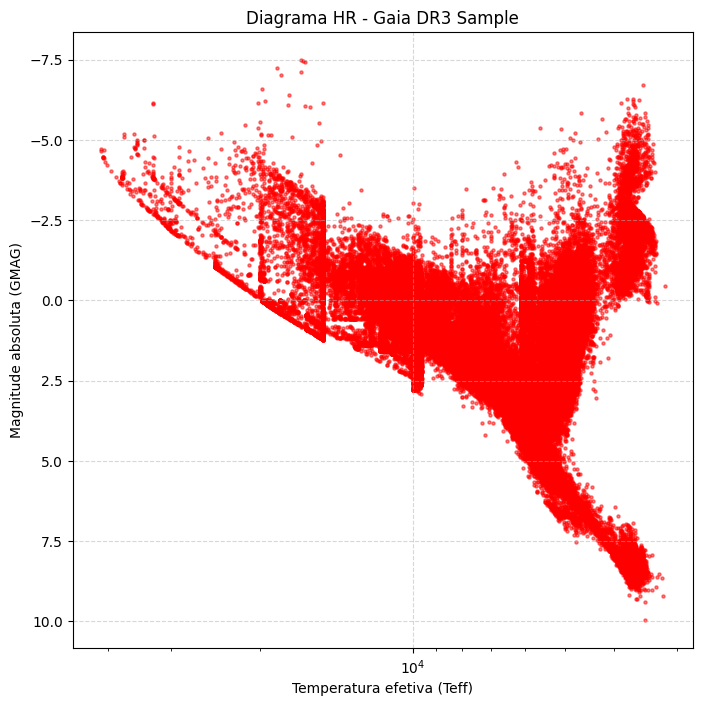

In [207]:
plt.figure(figsize=(8, 8))

plt.scatter(df_sample["Teff"], df_sample["GMAG"],
            s=5, color='red', alpha=0.5)

# Inversão dos eixos X e Y
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Escala logarítmica para a temperatura efetiva
plt.xscale('log')

plt.xlabel("Temperatura efetiva (Teff)")
plt.ylabel("Magnitude absoluta (GMAG)")
plt.title("Diagrama HR - Gaia DR3 Sample")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

O parâmetro GMAG é obtido considerando a distância até a estrela. Para estrelas pequenas, como anãs brancas, o valor estimado pode ser mais baixo, pois o raio é pequeno, dando a impressão de que são mais luminosas.

O diagrama abaixo mostra que a métrica `Lum-Flame`, que representa a luminosidade em múltiplos da luminosidade solar, é mais adequada para identificar estrelas. As candidatas a anã branca, com probabilidade acima de 90%, estão marcadas em ciano. Parece haver ruído nas temperaturas efetivas mais altas, o que também ocorre para anãs brancas que parecem estar em cima da sequência principal.

Esse ruído elevado tem uma interpretação física. Para estrelas de altas temperaturas, incertezas na medição do raio causam grandes variações de luminosidade, pois ela é proporcional a $R^2T_{eff}^4$. Além disso, o aumento de emissão no espectro UV, que não é detectado pelo Gaia, faz com que haja mais incerteza sobre a luminosidade.

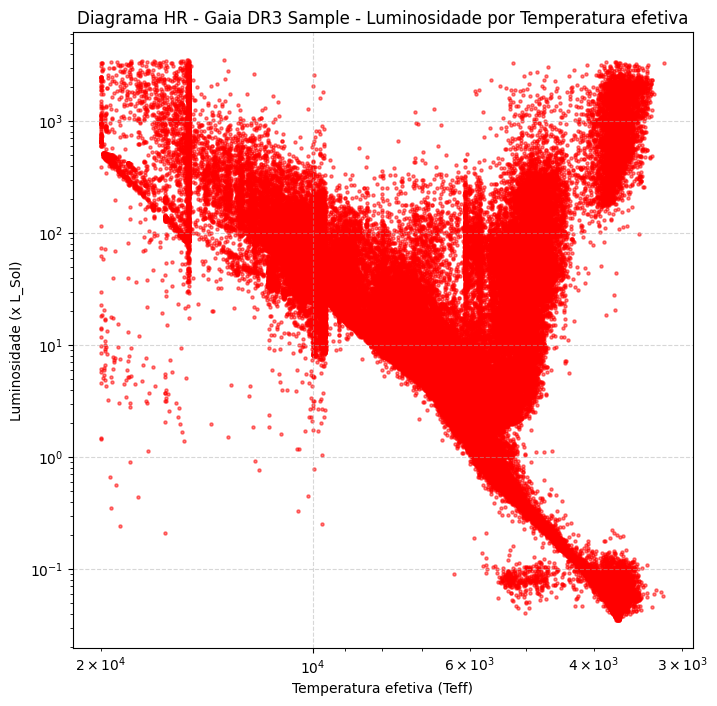

In [208]:
plt.figure(figsize=(8, 8))

plt.scatter(df_sample["Teff"], df_sample["Lum-Flame"],
            s=5, color='red', alpha=0.5)

plt.gca().invert_xaxis()

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Temperatura efetiva (Teff)")
plt.ylabel("Luminosidade (x L_Sol)")
plt.title("Diagrama HR - Gaia DR3 Sample - Luminosidade por Temperatura efetiva")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

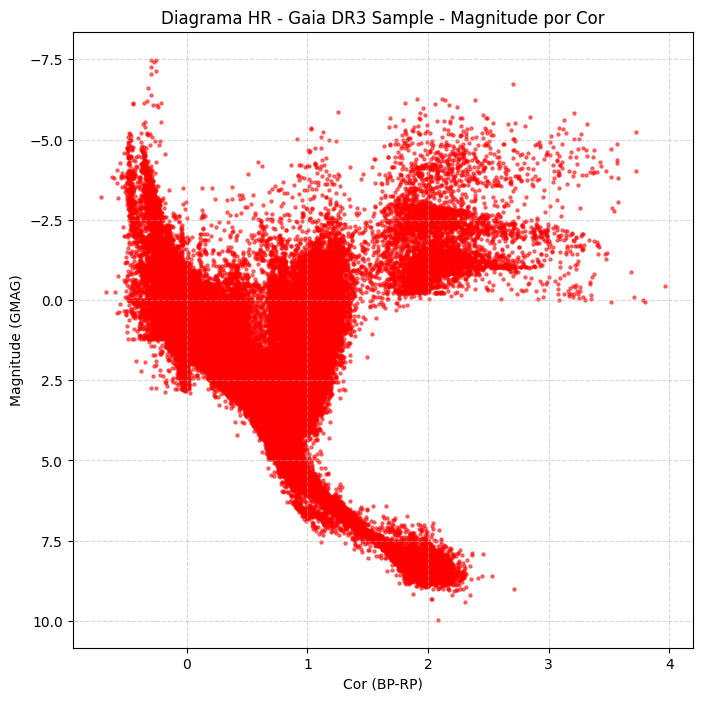

In [209]:
plt.figure(figsize=(8, 8))

plt.scatter(df_sample["BP-RP_corr"], df_sample["GMAG"],
            s=5, color='red', alpha=0.5)

plt.gca().invert_yaxis()

plt.xlabel("Cor (BP-RP)")
plt.ylabel("Magnitude (GMAG)")
plt.title("Diagrama HR - Gaia DR3 Sample - Magnitude por Cor")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Testes

In [210]:
wd = df[df["PWD"] > 0.8]
print(wd["Rad"].describe())

count    5304.000000
mean        2.748760
std         2.581213
min         0.934500
25%         1.600600
50%         1.889600
75%         2.629450
max        47.708400
Name: Rad, dtype: float64


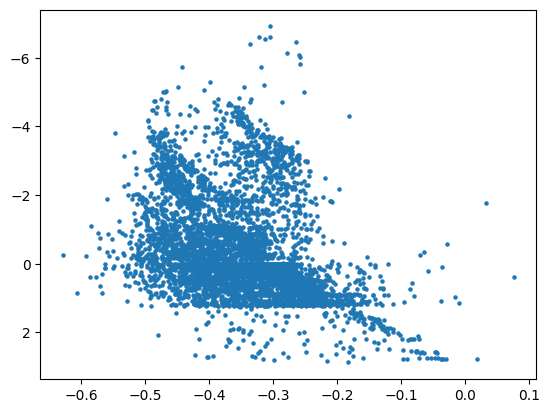

In [211]:
wd = df[df["PWD"] > 0.8]

plt.scatter(wd["BP-RP_corr"], wd["GMAG"], s=5)
plt.gca().invert_yaxis()
plt.show()

In [212]:
wd = df[df["PWD"] > 0.8]

print(wd["Plx"].describe())


count    5304.000000
mean        0.301969
std         0.233069
min         0.000200
25%         0.168075
50%         0.298450
75%         0.405325
max         6.816800
Name: Plx, dtype: float64


In [213]:
wd_near = df[
    (df["PWD"] > 0.8) &
    (df["Plx"] > 2)   # dentro de 500 pc
]

wd_near.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,7.000000,7.000000,7.000000,7.000000,4.000000,4.000000,1.000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.269586,-1.639243,17848.040857,719.497157,910.431452,4.738250,0.201,4.663771,0.992601,0.000057,0.0,3.646143,0.004756,0.016004,0.013667,0.496429,-0.279982
std,0.318283,1.308792,4120.306963,1146.722438,1051.800222,1.185149,NaN,2.118655,0.018044,0.000017,0.0,1.769468,0.001919,0.017131,0.011814,0.584788,0.107145
min,0.000100,-3.390700,11680.873000,161.200900,186.441770,3.354000,0.201,2.052300,0.951775,0.000050,0.0,2.345500,0.002816,0.002978,0.003961,0.000100,-0.362939
25%,0.000650,-2.600800,15838.700500,222.237650,298.027752,4.141500,0.201,3.386900,0.998317,0.000050,0.0,2.473150,0.003149,0.004681,0.004585,0.001200,-0.351523
50%,0.201200,-1.645000,16494.170000,348.154600,497.645170,4.703000,0.201,3.685100,0.999950,0.000050,0.0,2.574000,0.004490,0.011618,0.010873,0.374100,-0.335242
75%,0.442400,-0.673700,20483.382000,385.453650,1110.048870,5.299750,0.201,5.969600,0.999950,0.000051,0.0,4.420200,0.005878,0.018150,0.018064,0.815150,-0.247030
max,0.799700,0.110000,24117.078000,3311.742000,2459.993700,6.193000,0.201,8.196000,0.999950,0.000095,0.0,6.816800,0.007932,0.051766,0.035535,1.468100,-0.064587


In [214]:
wd_phys = df[
    (df["PWD"] > 0.8) &
    (df["GMAG"] > 8) &
    (df["BP-RP_corr"] < 0.5) &
    (df["Plx"] > 2)
]

wd_phys.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [215]:
print(df["Plx"].describe())


count    618751.000000
mean          1.485100
std           2.019299
min           0.000100
25%           0.323000
50%           0.864800
75%           1.648600
max          95.047700
Name: Plx, dtype: float64


In [216]:
print((df["Plx"] > 2).sum())
print((df["Plx"] > 5).sum())


121931
42200


In [217]:
wd_candidate = df[
    (df["Plx"] > 2) &
    (df["GMAG"] > 9) &
    (df["BP-RP_corr"] < 0.8)
]

wd_candidate.describe()

,E(BP-RP),GMAG,Teff,Dist,Lum-Flame,Mass-Flame,Age-Flame,Rad,PWD,Pstar,PGal,Plx,e_Gmag,e_BPmag,e_RPmag,AG,BP-RP_corr
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(df["GMAG"].describe())
# Isso explica a falta de anãs brancas reais no dataset, ele vai só até abaixo de 10 GMAG, ou seja, não pega estrelas com baixa luminosidade
# As estrelas que aparecem no diagrama nessa região são só ruído, já que estão com a luminosidade muito alta para serem anãs brancas

count    618751.000000
mean          2.267832
std           2.687822
min          -7.961700
25%           0.374500
50%           2.021800
75%           3.937000
max           9.963000
Name: GMAG, dtype: float64


# Teste - Direto do servidor

In [232]:
from astroquery.gaia import Gaia

query = """
SELECT TOP 100000
    gs.source_id,
    gs.ra, gs.dec,
    gs.parallax,
    gs.phot_g_mean_mag,
    gs.bp_rp,
    ap.teff_gspphot,
    gs.phot_g_mean_mag + 5*LOG10(gs.parallax/1000) + 5 AS abs_mag
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap
USING (source_id)
WHERE gs.parallax IS NOT NULL
AND gs.parallax_over_error > 5
AND ap.teff_gspphot IS NOT NULL
"""
job = Gaia.launch_job_async(query)
df = job.get_results().to_pandas()

IncompleteRead: IncompleteRead(1368008 bytes read, 3894971 more expected)

In [233]:
dfs = []
for min_mag, max_mag in [(0,5),(5,10),(10,15),(15,20)]:
    q = f"""
    SELECT TOP 50000
        gs.source_id,
        gs.ra, gs.dec,
        gs.parallax,
        gs.phot_g_mean_mag,
        gs.bp_rp,
        ap.teff_gspphot,
        gs.phot_g_mean_mag + 5*LOG10(gs.parallax/1000) + 5 AS abs_mag
    FROM gaiadr3.gaia_source AS gs
    JOIN gaiadr3.astrophysical_parameters AS ap
    USING (source_id)
    WHERE gs.parallax IS NOT NULL
    AND gs.parallax_over_error > 5
    AND ap.teff_gspphot IS NOT NULL
    AND gs.phot_g_mean_mag BETWEEN {min_mag} AND {max_mag}
    """
    job = Gaia.launch_job_async(q)
    dfs.append(job.get_results().to_pandas())

df_sample = pd.concat(dfs, ignore_index=True)


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [243]:
df = df_sample
df.describe()

,source_id,ra,dec,parallax,phot_g_mean_mag,bp_rp,teff_gspphot,abs_mag
count,1.507680e+05,150768.000000,150768.000000,150768.000000,150768.000000,150768.000000,150768.000000,150768.000000
mean,2.697645e+17,68.747827,21.140044,3.060894,13.218954,1.287495,5384.676758,4.631206
std,5.056558e+17,54.460669,19.367649,5.097524,3.485498,0.629236,1703.447510,2.952927
min,3.436113e+10,0.012571,-84.993899,0.092000,2.727835,-0.447706,2714.762207,-5.409835
25%,1.283373e+16,42.935942,8.071652,1.026680,9.687575,0.894276,4563.899780,2.698652
50%,3.404937e+16,48.877254,13.482485,1.729668,13.996033,1.174495,5212.513916,4.560262
75%,3.501709e+17,60.722918,28.993868,3.434500,16.160630,1.544776,5904.332153,6.480159
max,6.902503e+18,359.828544,89.569470,392.752945,18.999931,6.055547,41351.367188,13.821698


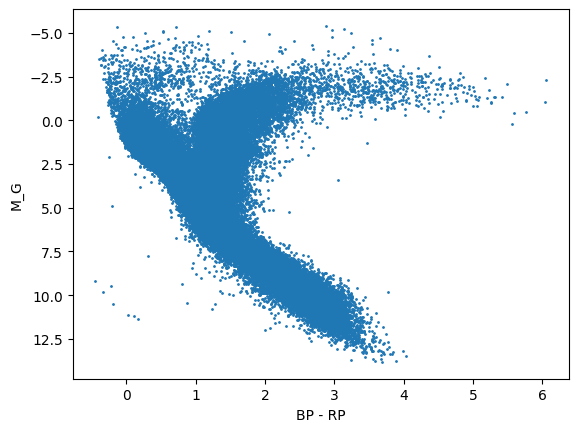

In [241]:
plt.figure()
plt.scatter(df["bp_rp"], df["abs_mag"], s=1)
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.show()

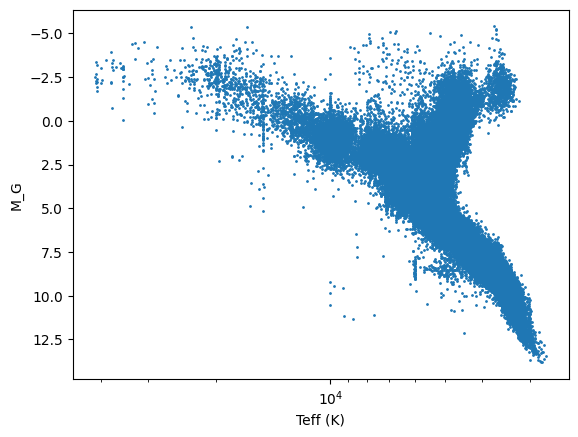

In [242]:
plt.figure()
plt.scatter(df["teff_gspphot"], df["abs_mag"], s=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()  # temperatura decresce para a direita
plt.xscale('log')
plt.xlabel("Teff (K)")
plt.ylabel("M_G")
plt.show()

In [253]:
query = """
SELECT TOP 100000
    gs.source_id,
    gs.parallax,
    gs.phot_g_mean_mag,
    gs.bp_rp,
    ap.teff_gspphot,
    gs.phot_g_mean_mag + 5*LOG10(gs.parallax/1000) + 5 AS abs_mag
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap
USING (source_id)
WHERE gs.parallax > 3.3
AND ap.teff_gspphot IS NOT NULL
"""
    
job = Gaia.launch_job_async(query)
df = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


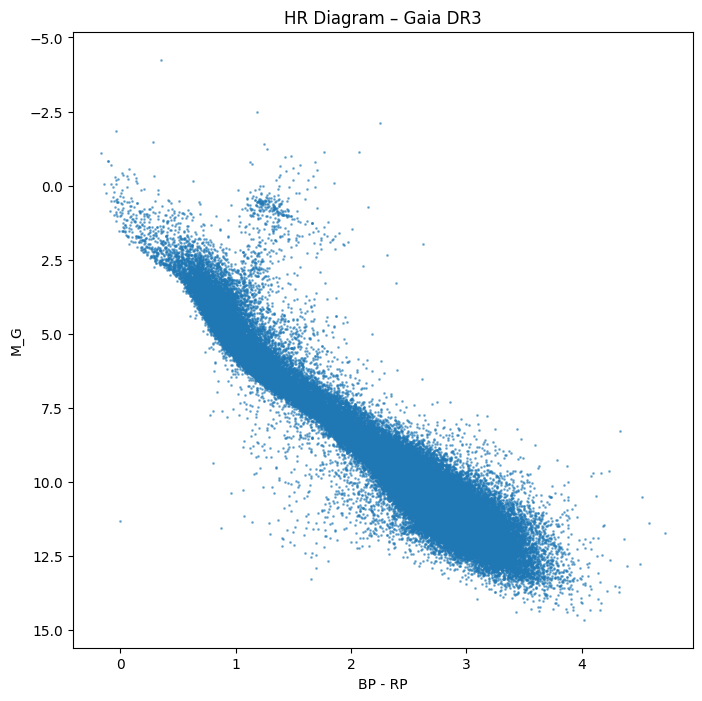

In [254]:
plt.figure(figsize=(8,8))
plt.scatter(df["bp_rp"], df["abs_mag"], s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.title("HR Diagram – Gaia DR3")
plt.show()


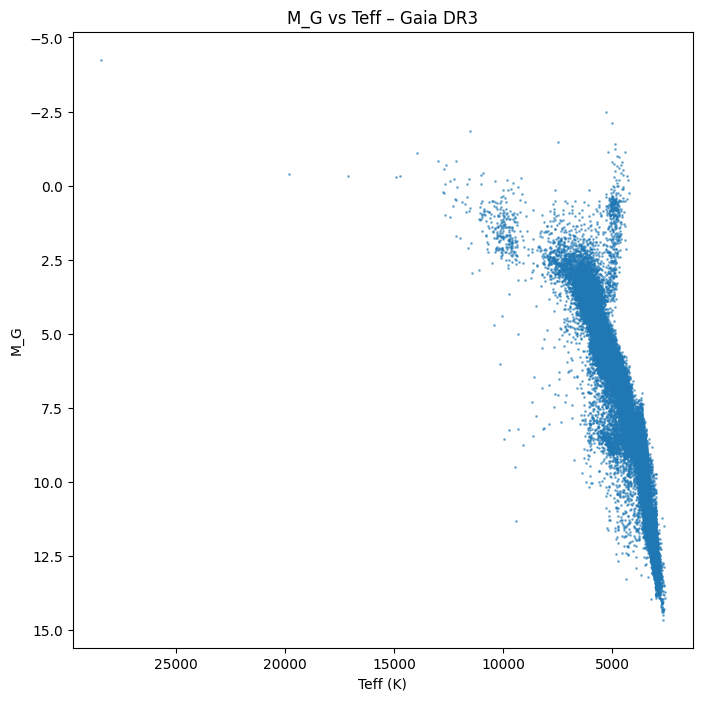

In [255]:
plt.figure(figsize=(8,8))
plt.scatter(df["teff_gspphot"], df["abs_mag"], s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("Teff (K)")
plt.ylabel("M_G")
plt.title("M_G vs Teff – Gaia DR3")
plt.show()


# Mais um teste

In [ ]:
def plot_HR_mag_bprp(dataframe):
    plt.figure(figsize=(8,8))
    plt.scatter(dataframe["bp_rp"], dataframe["abs_mag"], s=1, alpha=0.5)
    plt.gca().invert_yaxis()
    plt.xlabel("BP - RP")
    plt.ylabel("M_G")
    plt.title("HR Diagram – Gaia DR3")
    plt.show()

def plot_HR_mag_temp(dataframe):
    plt.figure()
    plt.scatter(df["teff_gspphot"], df["abs_mag"], s=1)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()  # temperatura decresce para a direita
    plt.xscale('log')
    plt.xlabel("Teff (K)")
    plt.ylabel("M_G")
    plt.show()

In [257]:
from astroquery.gaia import Gaia

query = """
SELECT TOP 200000
    gs.source_id,
    gs.parallax,
    gs.phot_g_mean_mag,
    gs.bp_rp,
    ap.teff_gspphot,
    gs.phot_g_mean_mag + 5*LOG10(gs.parallax/1000) + 5 AS abs_mag
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap
USING (source_id)
WHERE gs.parallax > 5
AND ap.teff_gspphot IS NOT NULL
"""
job = Gaia.launch_job_async(query)
df = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


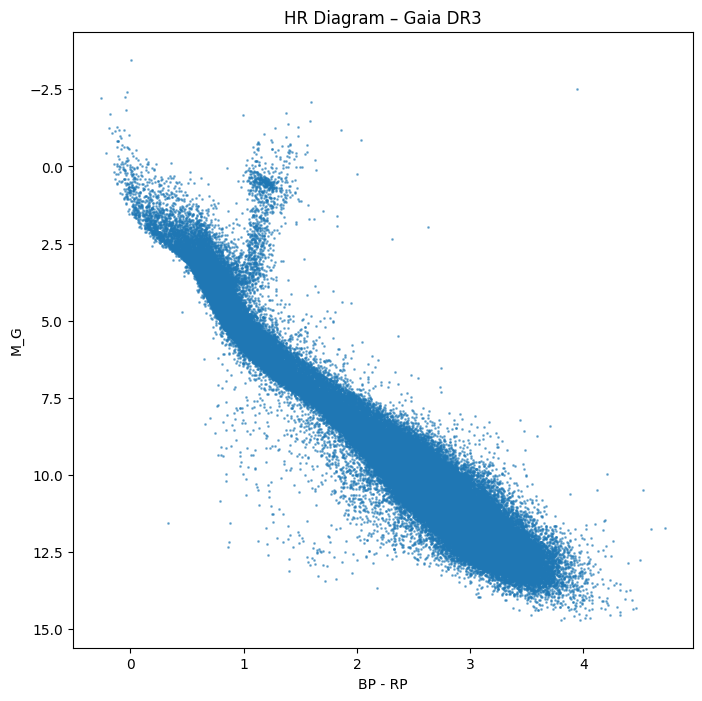

In [262]:
plot_HR_mag_temp(df)

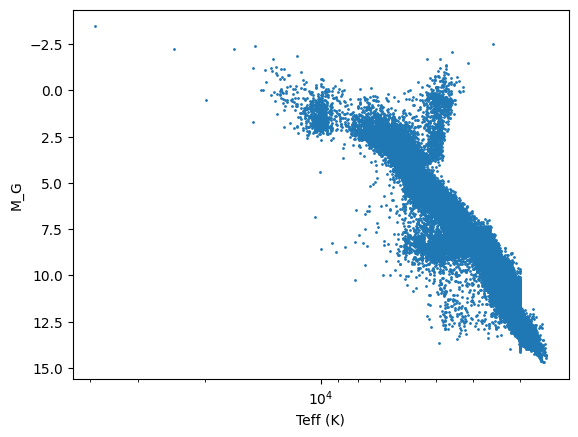

In [263]:
plot_HR_mag_bprp(df)

# Dataset direto do servidor

In [2]:
from astroquery.gaia import Gaia

query = """
SELECT TOP 300000
    gs.source_id,
    gs.parallax,
    gs.phot_g_mean_mag,
    gs.bp_rp,
    ap.teff_gspphot,
    gs.phot_g_mean_mag + 5*LOG10(gs.parallax/1000) + 5 AS abs_mag
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap
USING (source_id)
WHERE gs.parallax > 2
AND ap.teff_gspphot IS NOT NULL
"""
job = Gaia.launch_job_async(query)
df_servidor_plx2 = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
df_servidor_plx2.describe()

,source_id,parallax,phot_g_mean_mag,bp_rp,teff_gspphot,abs_mag
count,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,9.472273e+17,3.344221,16.097996,2.077445,4097.906250,8.527888
std,6.294689e+17,1.936653,2.425575,0.730310,954.860901,2.407802
min,3.436113e+10,2.000005,3.120973,-0.342836,2590.604492,-2.816237
25%,4.058095e+17,2.291564,14.485629,1.446371,3407.121887,6.816445
50%,8.782632e+17,2.748501,16.841018,2.308656,3633.894775,9.292691
75%,1.392556e+18,3.683837,18.077334,2.648747,4606.166260,10.373480
max,2.174804e+18,157.887931,18.999958,5.763694,19790.242188,14.630127


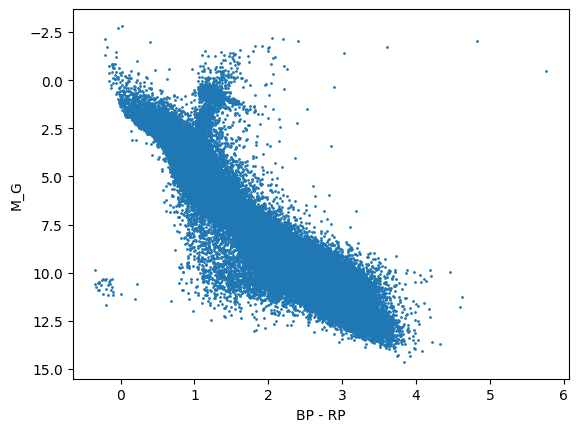

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df_servidor_plx2["bp_rp"], df_servidor_plx2["abs_mag"], s=1)
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.show()

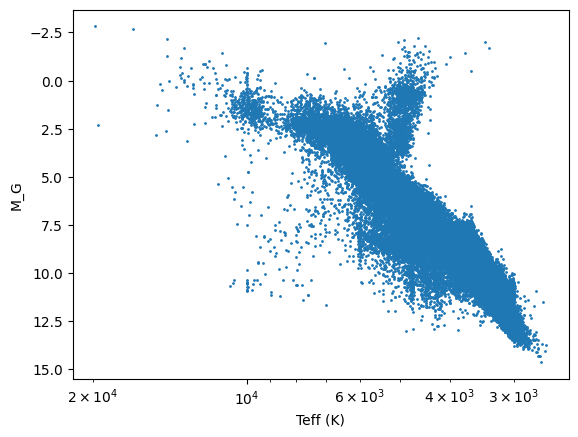

In [7]:
plt.figure()
plt.scatter(df_servidor_plx2["teff_gspphot"], df_servidor_plx2["abs_mag"], s=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()  # temperatura decresce para a direita
plt.xscale('log')
plt.xlabel("Teff (K)")
plt.ylabel("M_G")
plt.show()

In [11]:
from astroquery.gaia import Gaia
import pandas as pd

query1 = """
SELECT TOP 150000
    source_id,
    parallax,
    phot_g_mean_mag,
    bp_rp
FROM gaiadr3.gaia_source
WHERE parallax > 2
"""
job1 = Gaia.launch_job_async(query1)
df1 = job1.get_results().to_pandas()

print("Passo 1 concluído:", len(df1))

INFO: Query finished. [astroquery.utils.tap.core]
Passo 1 concluído: 150000


In [15]:
from astropy.table import Table

# Converter pandas → Astropy Table
upload_table = Table.from_pandas(df1[["source_id"]])

job2 = Gaia.launch_job_async(
    """
    SELECT
        ap.source_id,
        ap.teff_gspphot,
        ap.luminosity_gspphot
    FROM gaiadr3.astrophysical_parameters AS ap
    JOIN tap_upload.my_ids AS u
    ON ap.source_id = u.source_id
    """,
    upload_resource=upload_table,
    upload_table_name="my_ids"
)

df2 = job2.get_results().to_pandas()


500 Error 500:
null


HTTPError: Error 500:
null

In [ ]:
df = df1.merge(df2, on="source_id", how="inner")

print("Dataset final:", len(df))

In [17]:
query = """
SELECT
    gs.source_id,
    gs.parallax,
    gs.phot_g_mean_mag,
    gs.bp_rp,
    ap.teff_gspphot,
    ap.luminosity_gspphot
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap
ON gs.source_id = ap.source_id
WHERE
    gs.parallax > 2
    AND gs.ra BETWEEN 0 AND 60
    AND ap.teff_gspphot IS NOT NULL
"""


In [ ]:
import pandas as pd

dfs = [df1, df2, df3, df4, df5, df6]
df_final = pd.concat(dfs, ignore_index=True)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

In [20]:
def baixar_bloco_ra(ra_min, ra_max):

    query = f"""
    SELECT
        gs.source_id,
        gs.parallax,
        gs.parallax_over_error,
        gs.phot_g_mean_mag,
        gs.bp_rp,
        ap.teff_gspphot,
        ap.luminosity_gspphot
    FROM gaiadr3.gaia_source AS gs
    JOIN gaiadr3.astrophysical_parameters AS ap
    ON gs.source_id = ap.source_id
    WHERE
        gs.parallax > 2
        AND gs.parallax_over_error > 5
        AND gs.ra BETWEEN {ra_min} AND {ra_max}
        AND ap.teff_gspphot IS NOT NULL
        AND ap.luminosity_gspphot IS NOT NULL
    """

    job = Gaia.launch_job_async(query)
    return job.get_results().to_pandas()


In [ ]:
df["distance_pc"] = 1000 / df["parallax"]
df["M_G"] = df["phot_g_mean_mag"] - 5*np.log10(df["distance_pc"]) + 5


In [ ]:
plt.figure(figsize=(8,10))

plt.scatter(df["bp_rp"], df["M_G"],
            s=1, alpha=0.3)

plt.gca().invert_yaxis()

plt.xlabel("BP - RP")
plt.ylabel("Magnitude Absoluta (M_G)")
plt.title("Diagrama HR Observacional")

plt.show()


In [ ]:
plt.figure(figsize=(8,10))

plt.scatter(df["teff_gspphot"],
            np.log10(df["luminosity_gspphot"]),
            s=1, alpha=0.3)

plt.gca().invert_xaxis()

plt.xlabel("Temperatura Efetiva (K)")
plt.ylabel("log(L / L☉)")
plt.title("Diagrama HR Físico")

plt.show()


In [ ]:
query = """ SELECT TOP 300000
    source_id,
    parallax,
    parallax_over_error,
    phot_g_mean_mag,
    bp_rp,
    teff_gspphot,
    logg_gspphot
FROM gaiadr3.gaia_source
WHERE
    parallax > 1
    AND parallax_over_error > 5
    AND teff_gspphot IS NOT NULL
    AND logg_gspphot IS NOT NULL
"""

In [46]:
job = Gaia.launch_job_async(query)
df = job.get_results().to_pandas()

print("Total de estrelas:", len(df))


INFO: Query finished. [astroquery.utils.tap.core]
Total de estrelas: 200000


In [47]:
df["distance_pc"] = 1000 / df["parallax"]
df["M_G"] = df["phot_g_mean_mag"] - 5*np.log10(df["distance_pc"]) + 5
M_sun = 4.67
df["logL"] = -0.4 * (df["M_G"] - M_sun)


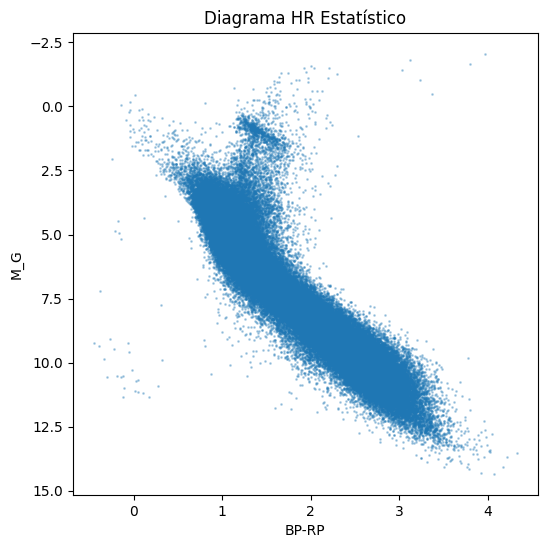

In [48]:
plt.figure(figsize=(6,6))

plt.scatter(df["bp_rp"],
            df["M_G"],
            s=1, alpha=0.3)

plt.gca().invert_yaxis()

plt.xlabel("BP-RP")
plt.ylabel("M_G")
plt.title("Diagrama HR Estatístico")

plt.show()


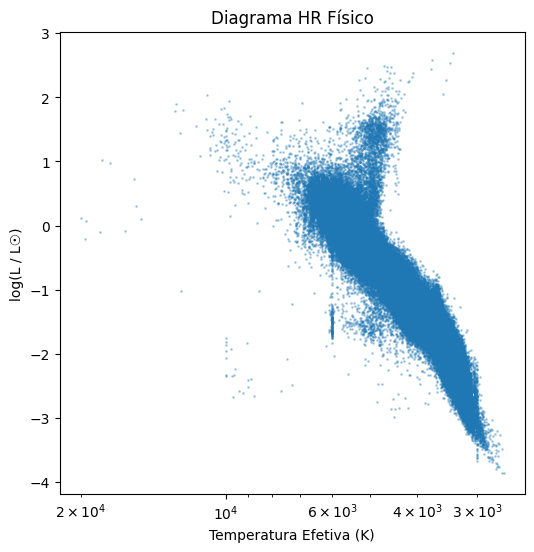

In [49]:
plt.figure(figsize=(6,6))

plt.scatter(df["teff_gspphot"],
            df["logL"],
            s=1, alpha=0.3)

plt.gca().invert_xaxis()
plt.xscale("log")

plt.xlabel("Temperatura Efetiva (K)")
plt.ylabel("log(L / L☉)")
plt.title("Diagrama HR Físico")

plt.show()


In [52]:
query = """ SELECT TOP 300000
    source_id,
    parallax,
    parallax_over_error,
    phot_g_mean_mag,
    bp_rp,
    teff_gspphot,
    logg_gspphot
FROM gaiadr3.gaia_source
WHERE
    parallax > 1
    AND parallax_over_error > 5
    AND teff_gspphot IS NOT NULL
    AND logg_gspphot IS NOT NULL
"""

In [53]:
job = Gaia.launch_job_async(query)
df = job.get_results().to_pandas()

print("Total de estrelas:", len(df))


INFO: Query finished. [astroquery.utils.tap.core]
Total de estrelas: 300000


In [54]:
dataset_novo = df.copy()

In [67]:
df = dataset_novo.copy()

In [68]:
df.describe()

,source_id,parallax,parallax_over_error,phot_g_mean_mag,bp_rp,teff_gspphot,logg_gspphot
count,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,3.976704e+16,2.203952,46.321293,16.341187,1.887802,4330.614746,4.526200
std,2.110448e+16,1.700179,72.071190,2.036250,0.639333,927.288879,0.288536
min,3.436113e+10,1.000007,5.000056,3.280453,-0.447706,2615.510742,0.497300
25%,2.202646e+16,1.282955,11.309032,15.016634,1.329110,3555.692383,4.392700
50%,4.187464e+16,1.684524,23.005305,16.778649,1.885362,4180.068604,4.553700
75%,5.780302e+16,2.481083,52.673263,18.024134,2.412621,4978.812744,4.681800
max,8.423919e+16,138.437091,3297.232178,18.999954,4.501435,19065.289062,5.383400


In [69]:
df["distance_pc"] = 1000 / df["parallax"]
df["M_G"] = df["phot_g_mean_mag"] - 5*np.log10(df["distance_pc"]) + 5

In [70]:
df.describe()

,source_id,parallax,parallax_over_error,phot_g_mean_mag,bp_rp,teff_gspphot,logg_gspphot,distance_pc,M_G
count,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,3.976704e+16,2.203952,46.321293,16.341187,1.887802,4330.614746,4.526200,586.880509,7.725211
std,2.110448e+16,1.700179,72.071190,2.036250,0.639333,927.288879,0.288536,234.085671,2.164097
min,3.436113e+10,1.000007,5.000056,3.280453,-0.447706,2615.510742,0.497300,7.223498,-2.308187
25%,2.202646e+16,1.282955,11.309032,15.016634,1.329110,3555.692383,4.392700,403.049764,6.128538
50%,4.187464e+16,1.684524,23.005305,16.778649,1.885362,4180.068604,4.553700,593.639553,7.942911
75%,5.780302e+16,2.481083,52.673263,18.024134,2.412621,4978.812744,4.681800,779.450546,9.391704
max,8.423919e+16,138.437091,3297.232178,18.999954,4.501435,19065.289062,5.383400,999.992841,14.331164


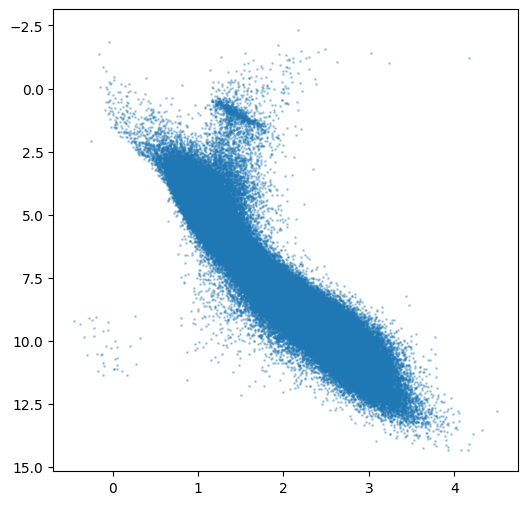

In [73]:
plt.figure(figsize=(6,6))

plt.scatter(df["bp_rp"],
            df["M_G"],
            s=1, alpha=0.3)

plt.gca().invert_yaxis()

plt.show()


In [ ]:
plt.figure(figsize=(6,6))

plt.scatter(df["bp_rp"],
            df["M_G"],
            s=1, alpha=0.3)

plt.gca().invert_yaxis()

plt.show()
